In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.datasets import mnist, cifar10
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from skimage import transform
from skimage import color
from IPython.display import display
from datetime import datetime
import keras.utils
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os

print(K.tensorflow_backend._get_available_gpus()) # if this is empty, then you don't have a gpu, or keras didn't find it
print('img data fmt: ', K.image_data_format()) # are images (RGB, x, y) or (x, y, RGB)?

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']
img data fmt:  channels_last


# Data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# convert from uint to floats, and normalize to [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

val_split = 0.2
val_cutoff = X_train.shape[0] - int(X_train.shape[0] * val_split)
X_train, X_val = X_train[:val_cutoff], X_train[val_cutoff:]
y_train, y_val = y_train[:val_cutoff], y_train[val_cutoff:]

print('X_train.shape = ', X_train.shape, ' y_train.shape = ', y_train.shape)
print('X_val.shape = ', X_val.shape, ' y_val.shape = ', y_val.shape)
print('X_test.shape = ', X_test.shape, ' y_test.shape = ', y_test.shape)

print('data type: ', type(X_train[0][0][0]))
print('label type: ', type(y_train[0][0]))

#plt.imshow(X_train[0], cmap='Greys')

X_train.shape =  (48000, 28, 28)  y_train.shape =  (48000, 10)
X_val.shape =  (12000, 28, 28)  y_val.shape =  (12000, 10)
X_test.shape =  (10000, 28, 28)  y_test.shape =  (10000, 10)
data type:  <class 'numpy.float32'>
label type:  <class 'numpy.float32'>


# Model - LeNet-5

* [pdf](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)
* [mnist demo](http://yann.lecun.com/exdb/lenet/)

In [3]:
def generate_leNet(pool_strides=(2,2), kernel_size=(5,5), lr=0.01):
    
    leNet = Sequential()
    ## C1 ##
    leNet.add(Conv2D(6, kernel_size,
                     activation='relu',
                     input_shape= (28,28,1),
                     padding='same'))
    leNet.add(MaxPooling2D(pool_size=(2,2)))
    ## C3 ##
    leNet.add(Conv2D(16, kernel_size, 
                     activation='relu'))
    leNet.add(MaxPooling2D(pool_size=(2,2)))
    ## C5 ##
    leNet.add(Conv2D(120, kernel_size, 
                     activation='relu'))
    leNet.add(Flatten())
    ## F6 ##
    leNet.add(Dense(84, activation='relu'))
    leNet.add(Dropout(0.5))
    ## Out ##
    leNet.add(Dense(10, activation='softmax'))

    leNet.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return leNet

# Train

In [4]:
def train_model(model, X_train, y_train, X_val, y_val,
                n_epochs=10, logdir=None, model_name=None):
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    
    if model_name is None:
        model_name = 'LeNet-5'
    
    if logdir is None:
        append = False
        logdir = "logs/run-{0}-{1}/".format(model_name, now)
        os.mkdir(logdir)
    else:
        append = True
    print('storing training data in ', logdir)

    
    # log stats for each epoch in a csv file
    csv_logger_cb = keras.callbacks.CSVLogger('{0}{1}.csv'.format(logdir, model_name), 
                                              separator=',', append=append)
    # save the current model weights if it has the best validation accuracy
    model_chkpt_cb = keras.callbacks.ModelCheckpoint(logdir + 'weights.ep{epoch:02d}-val_acc{val_acc:.3f}.hdf5', 
                                                     save_best_only=True, monitor='val_acc', mode='max')

    print('Training model ', model_name)
    
    X_train, X_val = (np.expand_dims(X_train, axis=-1),
                      np.expand_dims(X_val, axis=-1))
    
    hist = model.fit(X_train, y_train, batch_size=64, epochs=n_epochs,
                     validation_data=(X_val, y_val), 
                     callbacks=[csv_logger_cb, model_chkpt_cb])
    return hist

In [5]:
lenet = generate_leNet()
train_hist = train_model(lenet, X_train, y_train, X_val, y_val)


storing training data in  logs/run-LeNet-5-20190525024721/
Training model  LeNet-5
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 105us/step - loss: 0.3721 - acc: 0.8869 - val_loss: 0.0835 - val_acc: 0.9742
Epoch 2/10
48000/48000 [==============================] - 4s 74us/step - loss: 0.1070 - acc: 0.9701 - val_loss: 0.0602 - val_acc: 0.9832
Epoch 3/10
48000/48000 [==============================] - 4s 73us/step - loss: 0.0752 - acc: 0.9781 - val_loss: 0.0558 - val_acc: 0.9839
Epoch 4/10
48000/48000 [==============================] - 4s 74us/step - loss: 0.0596 - acc: 0.9832 - val_loss: 0.0509 - val_acc: 0.9852
Epoch 5/10
48000/48000 [==============================] - 3s 72us/step - loss: 0.0489 - acc: 0.9859 - val_loss: 0.0506 - val_acc: 0.9869
Epoch 6/10
48000/48000 [==============================] - 3s 72us/step - loss: 0.0405 - acc: 0.9882 - val_loss: 0.0567 - val_acc: 0.9863
Epoch 7/10
48000/48000 [====================

In [9]:
lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
__________

In [6]:
test_loss, test_acc = lenet.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(test_loss, test_acc)

10000/10000 [==============================] - 0s 40us/step
0.04046410774023907 0.9885


# Save/Load Model

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


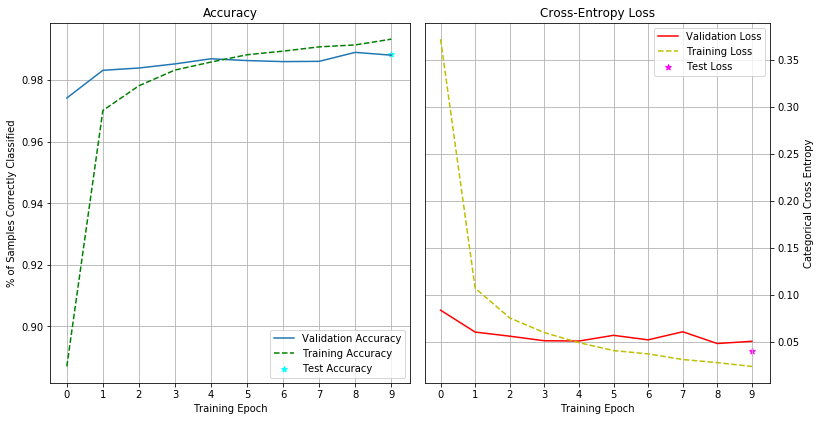

In [7]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_axes([0.0, 0.0, 0.5, 1.0])
ax1.plot(train_hist.history['val_acc'])
ax1.plot(train_hist.history['acc'], 'g--')
ax1.scatter([9], [test_acc], c='cyan', marker='*')
ax1.legend(['Validation Accuracy', 'Training Accuracy', 'Test Accuracy'])
ax1.set_title('Accuracy')
ax1.set_xticks(range(10))
ax1.set_xlabel('Training Epoch')
ax1.set_ylabel('% of Samples Correctly Classified')
ax1.grid('on')

ax2 = fig.add_axes([0.52, 0.0, 0.48, 1.0])
ax2.plot(train_hist.history['val_loss'], 'r')
ax2.plot(train_hist.history['loss'], 'y--')
ax2.scatter([9], [test_loss], c='magenta', marker='*')
ax2.legend(['Validation Loss', 'Training Loss', 'Test Loss'])
ax2.set_title('Cross-Entropy Loss')
ax2.yaxis.set_ticks_position('right')
ax2.set_xticks(range(10))
ax2.set_xlabel('Training Epoch')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Categorical Cross Entropy')
ax2.grid('on')

fig.savefig('leNet_training.png', dpi=150, bbox_inches='tight')

In [8]:
lenet.save('lenet-5_10ep.h5')

In [3]:
lenet = load_model('lenet-5_10ep.h5')

In [4]:
lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
__________

In [5]:
def get_layer_activations(model=None, layer_ind=1, input_img=None, save_img=False):

    if model is None:
        model = load_model('lenet-5_10ep.h5')
    
    # LAYER 0 => return input image
    if layer_ind == 0:
        return X_test[test_ind]
    
    # LAYERS 1-3 => return feature maps from conv layers
    elif layer_ind < 4:
        test_img = np.expand_dims(input_img, axis=0)
        layer_name = 'conv2d_{}'.format(layer_ind)
        layer_model = Model(inputs=model.input,
                            outputs=model.get_layer(layer_name).output)
        pred = layer_model.predict(np.expand_dims(test_img, axis=-1))
        n_filter = pred.shape[-1]  
        n_row = int(np.ceil(np.sqrt(n_filter)))
        n_col = n_filter // n_row
        #print(n_row, n_col)
        im_size = pred.shape[1:3]
        #print(im_size)
        activations_grid = np.empty(shape=(im_size[0] * n_row, 
                                           im_size[1] * n_col))
        #print(activations_grid.shape)
        filter_index = 0
        for i in range(n_row):
            for j in range(n_col):
                x = im_size[0] # store the image size for indexing
                activations_grid[i*x: (i+1)*x, 
                                 j*x: (j+1)*x] = pred[0,:,:, filter_index]
                filter_index += 1

        return activations_grid
    
    # LAYERS 4 and 5 => return activations from dense layers
    elif layer_ind <= 5:
        test_img = np.expand_dims(input_img, axis=0)
        layer_name = 'dense_{}'.format(layer_ind-3) # 'dense_1 - dense_2 for layers 4,5'
        layer_model = Model(inputs=model.input,
                            outputs=model.get_layer(layer_name).output)
        pred = layer_model.predict(np.expand_dims(test_img, axis=-1))
        if layer_ind < 5:
            return pred.reshape((6,-1))
        else:
            return pred

In [13]:
def plot_layer_outputs(model, input_img, save_img=False, fname='000.png'):

    if model is None:
        model = load_model('lenet-5_10ep.h5')
    
    n_layer = 6
     
    #test_ind = np.random.randint(X_test.shape[0])
    #test_ind = 2
    #test_img = X_test[test_ind]
    test_img = input_img
    
    fig = plt.figure(figsize=(20,5))

    w = 1/n_layer
    im_width = 0.8*w
    arr_width = 0.2*w

    input_ax = fig.add_axes([0.0,1.0, im_width,1.0])
    input_ax.imshow(test_img)
    input_ax.axis('off')
    input_ax.set_title('Input')
    for i in range(1,(n_layer*2)-1):
        if i%2 == 0: # even => show activations
            left = (i//2)*(im_width + arr_width)
            new_ax = fig.add_axes([left,1.0, im_width,1.0])
            # CONV LAYERS
            if (i//2 < 4):
                new_ax.imshow(get_layer_activations(model=model, layer_ind=i//2, input_img=test_img))
                new_ax.set_title('Convolutional Layer {}'.format(i//2))
                new_ax.axis('off')
            # DENSE LAYERS
            elif (i//2 < 5):
                new_ax.matshow(get_layer_activations(model=model, layer_ind=i//2, input_img=test_img))
                new_ax.set_title('Dense Layer {}'.format(i//2 - 3))
                new_ax.axis('off')
            # OUTPUT LAYER
            else:
                pred = get_layer_activations(model=model, layer_ind=i//2, input_img=test_img)
                new_ax.matshow(pred)
                new_ax.set_title('Output Layer')
                new_ax.axis('on')
                new_ax.set_yticks([])
                new_ax.set_ylabel('')
                new_ax.set_xticks(range(10))
                new_ax.xaxis.set_ticks_position('bottom')
                pred_label = np.argmax(pred[0])
                #true_label = np.argmax(y_test[test_ind])
                new_ax.text(0,4, 'Prediction: ')
                confidence = pred[0, pred_label] * 100
                fd = {'fontsize' : 48, 
                      'weight' : 'bold'}
                if confidence > 98.0: 
                    new_ax.text(3,4, '{0}'.format(pred_label), fontdict=fd)
                else:
                    new_ax.text(3,4, '[?]')
                new_ax.text(0,5, 'Confidence: {0:.6f}%'.format(confidence))

        else: # odd => show arrow
            left = ((i//2)+1) * im_width + (i//2) * arr_width
            new_ax = fig.add_axes([left,1.0, arr_width,1.0])
            arrow_tail = (0.0, 0.5)
            arrow_head = (1.0, 0.5)
            arrow = mpatches.FancyArrowPatch(arrow_tail, arrow_head,
                                         mutation_scale=40)
            new_ax.add_patch(arrow)
            new_ax.axis('off')
    if save_img:
        fig.savefig(fname, 
                    dpi=150, bbox_inches='tight', facecolor='white')
    fig.clf()

In [14]:

plot_layer_outputs(lenet, input_img=X_test[2], save_img=True, fname='{:06d}.png'.format(i))

<Figure size 1440x360 with 0 Axes>

In [15]:
#####################################################
###  WARNING: THIS CELL HAS A LONG ASS  RUNTIME  ####
#####################################################
## break out of the second for-loop early to debug ##
#####################################################



im_size = (28,28)
n_test_img = 10
# a vertical 'tape' of n_test_img images from the test set
tape = np.empty(shape=(im_size[0] * n_test_img,
                       im_size[0]))
for i in range(n_test_img-1):
    tape[i*28 : (i+1)*28, :] = X_test[i]
# last sample on tape is same as first => infinite loop
tape[(n_test_img - 1)*28 : (n_test_img)*28, :] = X_test[0]

    

for t in range(0, tape.shape[0]-28, 2):
    tape_head = tape[t : t+28, :]
    plot_layer_outputs(lenet, input_img=tape_head, 
                       save_img=True, fname='frames\\{:03d}.png'.format(t))
    
print('created {} frames'.format(i))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


created 8 frames


<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>